In [1]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
#import dataset
fatigue_df = pd.read_csv('../Data/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [4]:
fatigue_df.info()

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [5]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,1067.63,1020,1.0,25,700,2.0,1.25,-1.0,0.2,84.90,...,0.050,0.0025,0.000,0.004,0.00,0.340,4.00,0.70,0.500,3.70
1,685.38,1025,2.0,450,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
2,700.06,1025,2.0,400,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
3,711.56,1025,2.0,425,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
4,649.41,1025,2.0,500,1025,2.0,1.00,0.0,0.0,85.01,...,0.065,0.0020,0.090,0.000,0.00,0.305,4.02,0.71,0.505,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,293.94,0,0.0,750,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
216,282.17,0,0.0,600,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
217,253.59,0,0.0,25,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00
218,180.72,0,0.0,400,1300,4.0,0.00,0.0,20.0,52.39,...,0.016,0.5300,0.002,0.023,0.00,0.000,0.00,18.70,0.000,0.00


In [6]:
# Convert the features into floats
features = features.astype('float64')

In [7]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
Pearson CC: 0.9436501270245273
R2 score: 0.8854042039449185
RMSE: 0.6710556673498786
MAE: 0.4214228746003455
Coverage: 88.63636363636363
Pearson R2 median: 0.9436501270245273
R2 median: 0.8854042039449185
RMSE median: 0.6710556673498786
Interval Width: 2.3216802233970553
Composite Metric: 0.7724533619616004


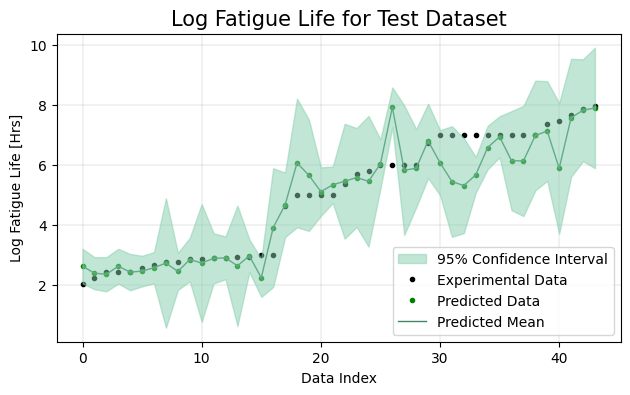

********************
Run # 1 Fold # 2
Pearson CC: 0.939957810430663
R2 score: 0.8743260431934892
RMSE: 0.6478085922675243
MAE: 0.415376812041929
Coverage: 88.63636363636363
Pearson R2 median: 0.939957810430663
R2 median: 0.8743260431934892
RMSE median: 0.6478085922675243
Interval Width: 2.0206314389267623
Composite Metric: 0.7884964282821428


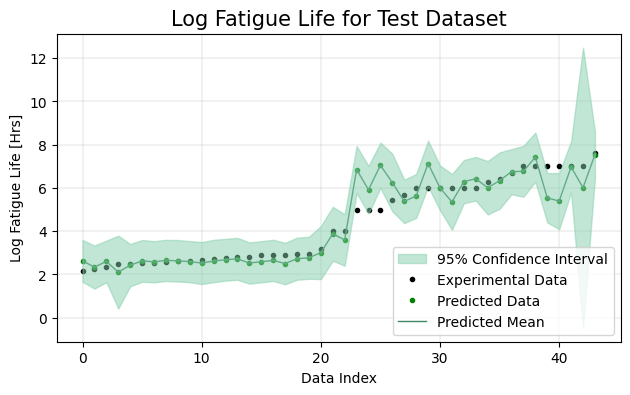

********************
Run # 1 Fold # 3


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9538374409680467
R2 score: 0.909315344103065
RMSE: 0.5531549074470831
MAE: 0.37083195302169897
Coverage: 93.18181818181817
Pearson R2 median: 0.9538374409680467
R2 median: 0.909315344103065
RMSE median: 0.5531549074470831
Interval Width: 2.166964238196141
Composite Metric: 0.8142324069198633


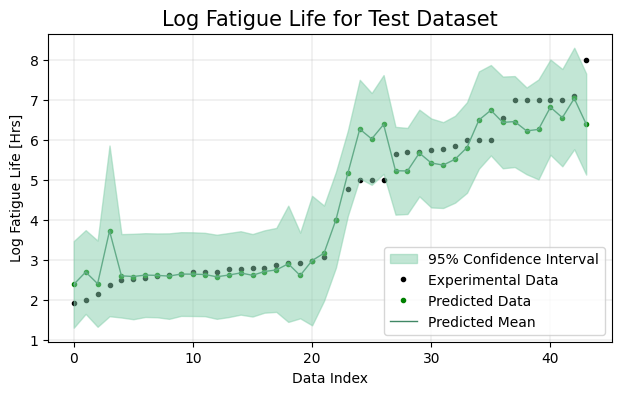

********************
Run # 1 Fold # 4


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Pearson CC: 0.9331698956927651
R2 score: 0.8663164895467108
RMSE: 0.6939763120043463
MAE: 0.46138630254139185
Coverage: 90.9090909090909
Pearson R2 median: 0.9331698956927651
R2 median: 0.8663164895467108
RMSE median: 0.6939763120043463
Interval Width: 2.0688423356131125
Composite Metric: 0.8026587097291265


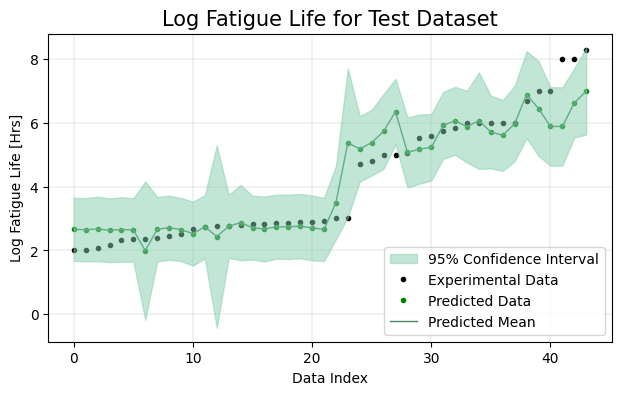

********************
Run # 1 Fold # 5
Pearson CC: 0.9356909643752451
R2 score: 0.8753328682789826
RMSE: 0.6568162691280256
MAE: 0.4674897304613903
Coverage: 93.18181818181819
Pearson R2 median: 0.9356909643752451
R2 median: 0.8753328682789826
RMSE median: 0.6568162691280256
Interval Width: 2.1981679210290457
Composite Metric: 0.8125947110501259


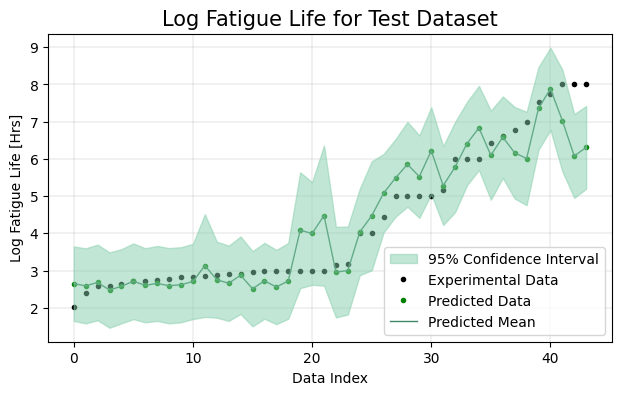

********************


In [8]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))
            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')

            print(f"Pearson R2 median: {pearsonr(y_test, df_test_median)[0]}")
            print(f"R2 median: {r2_score(y_test, df_test_median)}")
            print(f"RMSE median: {np.sqrt(mean_squared_error(y_test, df_test_median))}")

            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            y_pred = y_pred_test
            y_std = y_pred_unc_test
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.squeeze(y_pred) - 2*np.squeeze(y_std), np.squeeze(y_pred) + 2*np.squeeze(y_std), alpha=0.5, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.squeeze(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

            print(20*'*')

In [9]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.943650,0.885404,0.671056,0.421423,88.636364
1,0.939958,0.874326,0.647809,0.415377,88.636364
2,0.953837,0.909315,0.553155,0.370832,93.181818
3,0.933170,0.866316,0.693976,0.461386,90.909091
4,0.935691,0.875333,0.656816,0.467490,93.181818


In [10]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.941261,0.00724,0.882139,0.014879,0.644562,0.04829,0.427302,0.03505,90.909091,2.032789


In [11]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,88.636364,2.321680,0.772453
1,88.636364,2.020631,0.788496
2,93.181818,2.166964,0.814232
3,90.909091,2.068842,0.802659
4,93.181818,2.198168,0.812595


In [12]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,90.909091,2.032789,2.155257,0.105135,0.798087,0.015755
